# ML4EO - Team 2

> Summer School in Pavia, 2023.06.05. - 2023.06.09.

This is the notebook for the BIP course Machine Learning for Earth Observation. The members of Team 2 are the following:

- Team Lead: Jules Bourcier
- Dario Perregrini
- Patricia Camparada
- Olivér Angyal

## Topic

Monitoring the water extents of the Po River flowing south of Cremona during Spring-Summer 2022 (the lack of precipitations and the severe drought resulted in a big reduction of the water content in the river, down by more to -8 m w.r.t. the usual level).

> Team specific task: monitoring water extents with **multispectral sensors**

## Datasets


In [65]:
import pandas as pd
import numpy as np

### Ancillary data


In [86]:
!pip install --no-cache-dir torch torchvision --quiet
!pip install gdown --quiet
!gdown 1m3oRkElw3WGTwfrHbnD2iQKXz-FlfIga # ancillary data

Downloading...
From: https://drive.google.com/uc?id=1m3oRkElw3WGTwfrHbnD2iQKXz-FlfIga
To: /kaggle/working/Cremona SIAP - Livello Idrometrico - 2023-01-12.csv
100%|█████████████████████████████████████████| 309k/309k [00:00<00:00, 106MB/s]


In [84]:
ancillary_data_path = (
    "/kaggle/working/Cremona SIAP - Livello Idrometrico - 2023-01-12.csv"
)

ancillary_df = pd.read_csv(ancillary_data_path, sep=";")
ancillary_df.rename(
    columns={
        "Orario": "Hours",
        "Cremona SIAP - Livello Idrometrico - 15970 (m)": "Hydrometric level",
        "Variazione": "Variation",
        "Valore assoluto": "Absolute value",
    },
    inplace=True,
)
ancillary_df.head()

,Hours,Hydrometric level,Variation,Absolute value
0,2022-01-12 01:00,-6.64,NaN,-6.64
1,2022-01-12 02:00,-6.64,0.00,-6.64
2,2022-01-12 03:00,-6.64,0.00,-6.64
3,2022-01-12 04:00,-6.65,-0.01,-6.65
4,2022-01-12 05:00,-6.65,0.00,-6.65


In [105]:
print(f"Number of data points: {len(ancillary_df)}")

Number of data points: 8778


In [ ]:
ancillary_df["Hydrometric level"] = ancillary_df["Hydrometric level"].replace(
    "", np.nan
)
ancillary_df.loc[ancillary_df["Hydrometric level"] == "-", "Hydrometric level"] = np.nan
ancillary_df["Hydrometric level"] = ancillary_df["Hydrometric level"].astype(float)

In [93]:
print(
    "Hydrometric level missing values: ",
    ancillary_df["Hydrometric level"].isnull().sum(),
)

Hydrometric level missing values:  78


In [95]:
ancillary_df.loc[ancillary_df["Variation"] == "-", "Variation"] = np.nan
ancillary_df["Variation"] = ancillary_df["Variation"].astype(float)

In [100]:
print("Variation missing values: ", ancillary_df["Variation"].isnull().sum())

Variation missing values:  91


In [114]:
ancillary_df["Absolute value"] = ancillary_df["Absolute value"].abs()
print("Absolute value missing values: ", ancillary_df["Absolute value"].isnull().sum())

Absolute value missing values:  78


<AxesSubplot: xlabel='Hours'>

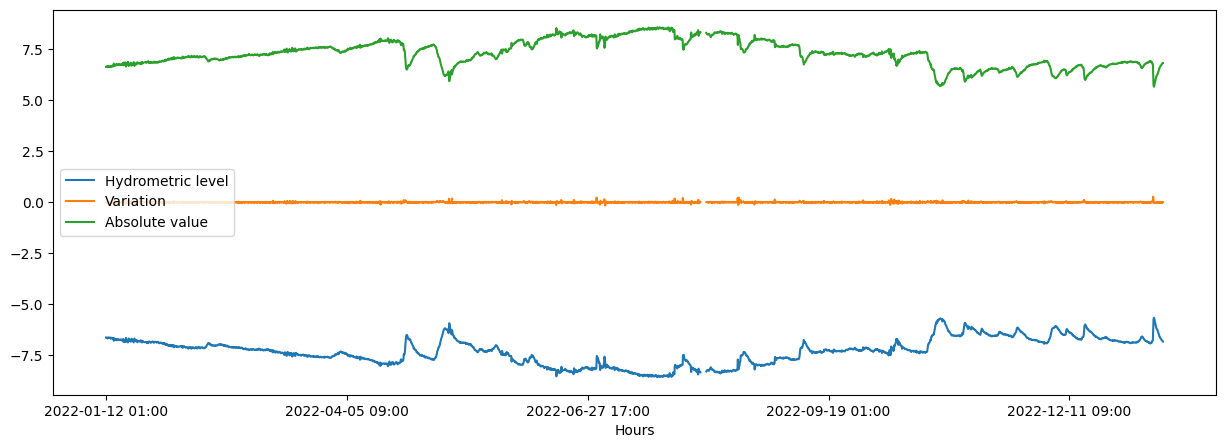

In [115]:
ancillary_df.set_index("Hours").plot(figsize=(15, 5))

### Sentinel-2

Multispectral data in the period of interest.

The list of bands [[Source]](https://hatarilabs.com/ih-en/how-many-spectral-bands-have-the-sentinel-2-images):

| Bands                         | Central Wavelength (µm) | Resolution (m) |
| ----------------------------- | ----------------------- | -------------- |
| Band 1 - Coastal aerosol      | 0.443                   | 60             |
| Band 2 - Blue                 | 0.490                   | 10             |
| Band 3 - Green                | 0.560                   | 10             |
| Band 4 - Red                  | 0.665                   | 10             |
| Band 5 - Vegetation Red Edge  | 0.705                   | 20             |
| Band 6 - Vegetation Red Edge  | 0.740                   | 20             |
| Band 7 - Vegetation Red Edge  | 0.783                   | 20             |
| Band 8 - NIR                  | 0.842                   | 10             |
| Band 8A - Vegetation Red Edge | 0.865                   | 20             |
| Band 9 - Water vapour         | 0.945                   | 60             |
| Band 10 - SWIR - Cirrus       | 1.375                   | 60             |
| Band 11 - SWIR                | 1.610                   | 20             |
| Band 12 - SWIR                | 2.190                   | 20             |


In [89]:
# meta info seems to be useless
sentinel_2_meta_path = (
    "/kaggle/input/sentinel-2-cremona/sentinel-2-cremona/S2_Cremona_DESCENDING_info.csv"
)

sentinel_2_meta_df = pd.read_csv(sentinel_2_meta_path)
sentinel_2_meta_df.head()

,system:index,.geo
0,20220307T101759_20220307T102247_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,20220307T101759_20220307T102247_T32TNQ,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,20220309T100841_20220309T101722_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,20220309T100841_20220309T101722_T32TNQ,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,20220322T101711_20220322T102531_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [133]:
import os
import rasterio
from typing import List, Tuple
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import numpy as np

from torchvision.transforms import Compose, ToTensor


class S2(Dataset):
    def __init__(
        self,
        root: str = "/kaggle/input/sentinel-2-cremona/sentinel-2-cremona",
        transform: Compose = Compose([ToTensor()]),
    ):
        self.root = os.path.join(root, "images")
        self.transform = transform
        self.files = self.load_files(self.root)
        self.bands = self.get_bands()
        self.readable_band_names = {
            "B2": "B2 - Blue",
            "B3": "B3 - Green",
            "B4": "B4 - Red",
            "B5": "B5 - Red Edge 1",
            "B6": "B6 - Red Edge 2",
            "B7": "B7 - Red Edge 3",
            "B8A": "B8A - NIR Narrow",
            "B8": "B8 - NIR Wide",
            "B11": "B11 - SWIR 1",
            "B12": "B12 - SWIR 2",
        }

    @staticmethod
    def load_files(root: str) -> List[str]:
        return os.listdir(root)

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> torch.Tensor:
        file = self.files[idx]
        with rasterio.open(os.path.join(self.root, file)) as data:
            img = data.read()
            img = img.transpose(1, 2, 0)  # CHW
        x = self.transform(img)
        return x

    def get_bands(self) -> Tuple[str]:
        file = self.files[0]
        with rasterio.open(os.path.join(self.root, file)) as data:
            return data.descriptions

    def get_band_index(self, band_name):
        return self.bands.index(band_name)

    def plot_image(self, idx, band_name) -> None:
        colormap = None

        if band_name in ["B2", "B3", "B4"]:
            colormap = "viridis"
        elif band_name in ["B5", "B6", "B7"]:
            colormap = "pink"
        elif band_name in ["B8A", "B8"]:
            colormap = "gray"
        elif band_name in ["B11", "B12"]:
            colormap = "hot"

        band_idx = self.bands.index(band_name)

        img = self[idx]
        band = img[band_idx, :, :]

        plt.imshow(band, cmap=colormap)
        plt.axis("off")
        plt.title(f"{self.readable_band_names[band_name]}")
        plt.show()

In [134]:
dataset = S2()

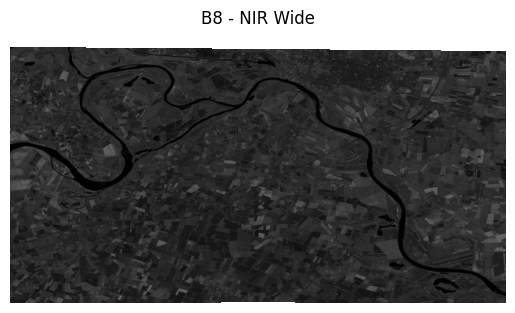

In [139]:
dataset.plot_image(0, "B8")

## Task 1

To extract the water extents as accurately as possible by classifying the data or by using water-related indexes.


## Task 2

To compute the total water surface extents statistics (histogram, mean, variance, max and min values) in the period of interest.


## Task 3

To find possible correlations between the measurements extracted from EO data and those on the ground.


## Task 4

To build a regression model for the water extent and/or water level measures for nowcasting purposes (i.e., forecasting at a very close time value).
